In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import time
import geopy.distance
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
import sklearn.cluster
import ast
from shapely.geometry import MultiPoint

%matplotlib inline
pd.set_option('display.max_colwidth', 10)


## loading scraped files

In [27]:
def events_to_venues(df_events):
    venues = df_events.venue
    venues = [ast.literal_eval(x) if pd.notnull(x) else dict() for x in list(venues)]
    df_venues = pd.DataFrame(venues, columns=venues[0].keys())
    return df_venues

In [28]:
GROUPS_CSV = "groups.csv"
EVENTS_CSV = "events.csv"
VENUES_CSV = "venues.csv"


df_groups = pd.read_csv(GROUPS_CSV)
df_events = pd.read_csv(EVENTS_CSV)
df_venues = pd.read_csv(VENUES_CSV)
df_old_events = pd.read_csv('_' + EVENTS_CSV)
df_old_venues = pd.read_csv('_' + VENUES_CSV)


Groups have events which have venues  
groups > events > venues

# First Impressions

In [29]:
df_groups.head()

,Unnamed: 0,level_0,category,city,country,created,description,group_photo,id,index,...,members,name,organizer,rating,timezone,topics,urlname,utc_offset,visibility,who
0,0,0,{'name...,Sydney,AU,152386...,<p>I h...,NaN,28179783,NaN,...,17,Blockc...,{'memb...,0.0,Austra...,[{'url...,meetup...,36000000,public,Members
1,1,1,{'name...,Sydney,AU,152387...,<p>Dun...,{'high...,28180718,NaN,...,13,Dungeo...,{'memb...,0.0,Austra...,[{'url...,Dungeo...,36000000,public,Members
2,2,2,{'name...,Sydney,AU,152388...,<p>Cal...,NaN,28182084,NaN,...,17,Sydney...,{'memb...,0.0,Austra...,[{'url...,meetup...,36000000,public,Members
3,3,3,{'name...,Sydney,AU,152389...,<p>WE ...,{'high...,28182760,NaN,...,207,I want...,{'memb...,0.0,Austra...,[{'url...,englis...,36000000,public,Members
4,4,4,{'name...,Sydney,AU,152389...,<p>Wel...,NaN,28182948,NaN,...,152,Japane...,{'memb...,0.0,Austra...,[{'url...,Japane...,36000000,public,Members


In [198]:
df_groups['short_cat'] = list(df_groups.category.apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else ""))

In [201]:
len(df_groups.short_cat.unique())

34

In [30]:
df_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3752 entries, 0 to 3751
Data columns (total 24 columns):
Unnamed: 0     3752 non-null int64
level_0        3752 non-null int64
category       3751 non-null object
city           3752 non-null object
country        3752 non-null object
created        3752 non-null int64
description    3751 non-null object
group_photo    1860 non-null object
id             3752 non-null int64
index          400 non-null float64
join_mode      3752 non-null object
lat            3752 non-null float64
link           3752 non-null object
lon            3752 non-null float64
members        3752 non-null int64
name           3752 non-null object
organizer      3673 non-null object
rating         3752 non-null float64
timezone       3752 non-null object
topics         3752 non-null object
urlname        3752 non-null object
utc_offset     3752 non-null int64
visibility     3752 non-null object
who            3752 non-null object
dtypes: float64(4), int64(6), ob

## Some columns are string dicts–this is how we get the category of the group

In [31]:
list(df_groups.category.apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else ""))

['tech',
 'games',
 'career/business',
 'language/ethnic identity',
 'language/ethnic identity',
 'fine arts/culture',
 'new age/spirituality',
 'health/wellbeing',
 'fitness',
 'new age/spirituality',
 'career/business',
 'new age/spirituality',
 'career/business',
 'language/ethnic identity',
 'sports/recreation',
 'pets/animals',
 'music',
 'socializing',
 'fine arts/culture',
 'career/business',
 'outdoors/adventure',
 'games',
 'writing',
 'health/wellbeing',
 'health/wellbeing',
 'fashion/beauty',
 'tech',
 'music',
 'career/business',
 'sports/recreation',
 'career/business',
 'outdoors/adventure',
 'health/wellbeing',
 'outdoors/adventure',
 'outdoors/adventure',
 'sports/recreation',
 'health/wellbeing',
 'religion/beliefs',
 'career/business',
 'health/wellbeing',
 'fine arts/culture',
 'fitness',
 'career/business',
 'health/wellbeing',
 'health/wellbeing',
 'socializing',
 'health/wellbeing',
 'parents/family',
 'photography',
 'book clubs',
 'LGBT',
 'LGBT',
 'career/busin

## Filter out any upcoming events because the venue is usually NaN

In [32]:
df_events = df_events[df_events.status=="past"]

In [33]:
df_events.loc[15403].event_url

'https://www.meetup.com/EntrepreneursInSydney/events/220684996/'

In [34]:
df_events.head()
df_events["time_timestamp"] = df_events.time.apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(x/1000.0)))
df_events["time_timestamp"]  = pd.to_datetime(df_events["time_timestamp"])


## Event growth over time

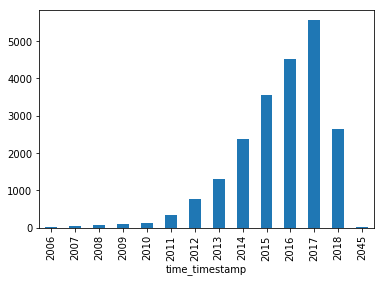

In [228]:
z = df_events.groupby(df_events.time_timestamp.dt.year).count()
# z.plot(x=z.time_timestamp, y=z.level_0)
z.time_timestamp.plot.bar()

In [36]:
df_events[df_events['time_timestamp'] > '2014-07-23 07:30:00']

,Unnamed: 0,level_0,created,description,duration,event_url,fee,group,headcount,how_to_find_us,...,status,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count,time_timestamp
27,27,27,140532...,<p>The...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140722...,140808...,36000000,{'coun...,public,0,NaN,53,2014-08...
28,28,28,140628...,<p>Bui...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140834...,140835...,36000000,{'coun...,public,0,NaN,51,2014-08...
29,29,29,140686...,<p>And...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140843...,140844...,36000000,{'coun...,public,0,NaN,0,2014-08...
30,30,30,140808...,<p>The...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140964...,140970...,36000000,{'coun...,public,0,NaN,52,2014-09...
31,31,31,140965...,<p>I a...,NaN,https:...,NaN,{'join...,0,NaN,...,past,141085...,141091...,36000000,{'coun...,public,0,NaN,34,2014-09...
32,32,32,141100...,<p>We'...,NaN,https:...,NaN,{'join...,0,NaN,...,past,141266...,141271...,39600000,{'coun...,public,0,NaN,55,2014-10...
33,33,33,141403...,<p>Our...,NaN,https:...,NaN,{'join...,0,If you...,...,past,141750...,141756...,39600000,{'coun...,public,0,NaN,88,2014-12...
34,34,34,142182...,<p>WE'...,NaN,https:...,NaN,{'join...,0,Follow...,...,past,142294...,142322...,39600000,{'coun...,public,0,NaN,66,2015-02...
35,35,35,142423...,<p>Our...,NaN,https:...,NaN,{'join...,0,NaN,...,past,142536...,142544...,39600000,{'coun...,public,0,NaN,69,2015-03...
36,36,36,142545...,<p>Wit...,NaN,https:...,NaN,{'join...,0,Walk p...,...,past,142839...,142847...,36000000,{'coun...,public,0,NaN,71,2015-04...


## We will train on 2017 event locations and use 2018 venues as a validation set.

In [37]:
events_df_2017 = df_events[df_events.time_timestamp.dt.year == 2017]
events_df_2018 = df_events[df_events.time_timestamp.dt.year == 2018]

In [38]:
events_df_2017.columns

Index(['Unnamed: 0', 'level_0', 'created', 'description', 'duration',
       'event_url', 'fee', 'group', 'headcount', 'how_to_find_us', 'id',
       'index', 'maybe_rsvp_count', 'name', 'photo_url', 'rating',
       'rsvp_limit', 'status', 'time', 'updated', 'utc_offset', 'venue',
       'visibility', 'waitlist_count', 'why', 'yes_rsvp_count',
       'time_timestamp'],
      dtype='object')

In [39]:
venues_df_2017 = events_to_venues(events_df_2017)
venues_df_2017 = venues_df_2017.set_index(events_df_2017.index)
venues_df_2017 = venues_df_2017[pd.notnull(venues_df_2017.lon)]  # remove all rows where lat lon is null.

In [40]:
venues_df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3607 entries, 62 to 21224
Data columns (total 9 columns):
country                   3607 non-null object
localized_country_name    3607 non-null object
city                      3607 non-null object
address_1                 3607 non-null object
name                      3607 non-null object
lon                       3607 non-null float64
id                        3607 non-null float64
lat                       3607 non-null float64
repinned                  3607 non-null object
dtypes: float64(3), object(6)
memory usage: 281.8+ KB


In [41]:
events_df_2017 = events_df_2017.loc[venues_df_2017.index]  # filter out all events with null coords

In [42]:
events_df_2017

,Unnamed: 0,level_0,created,description,duration,event_url,fee,group,headcount,how_to_find_us,...,status,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count,time_timestamp
62,62,62,147924...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148463...,148573...,39600000,{'coun...,public,0,NaN,99,2017-01...
63,63,63,148472...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148766...,148773...,39600000,{'coun...,public,0,NaN,130,2017-02...
64,64,64,148771...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149007...,149014...,39600000,{'coun...,public,0,NaN,118,2017-03...
65,65,65,149016...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149250...,149257...,36000000,{'coun...,public,0,NaN,113,2017-04...
66,66,66,149300...,<p>Wit...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149794...,149804...,36000000,{'coun...,public,0,NaN,133,2017-06...
67,67,67,149799...,<p>Tha...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150036...,150042...,36000000,{'coun...,public,0,NaN,126,2017-07...
68,68,68,150061...,<p>Cam...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150278...,150284...,36000000,{'coun...,public,0,NaN,110,2017-08...
69,69,69,150293...,<p>Sep...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150580...,150586...,36000000,{'coun...,public,0,NaN,122,2017-09...
70,70,70,150597...,<p><b>...,NaN,https:...,NaN,{'join...,0,We're ...,...,past,150822...,150854...,39600000,{'coun...,public,0,NaN,90,2017-10...
71,71,71,150396...,<p>PLE...,NaN,https:...,NaN,{'join...,0,NaN,...,past,150900...,150901...,39600000,{'coun...,public,0,NaN,1,2017-10...


## do this for 2018 data as well

In [43]:
venues_df_2018 = events_to_venues(events_df_2018)
venues_df_2018 = venues_df_2018.set_index(events_df_2018.index)
venues_df_2018 = venues_df_2018[pd.notnull(venues_df_2018.lon)]

In [44]:
events_df_2018 = events_df_2018.loc[venues_df_2018.index]  # filter out all events with null coords
events_df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 74 to 21377
Data columns (total 27 columns):
Unnamed: 0          1662 non-null int64
level_0             1662 non-null int64
created             1662 non-null int64
description         1638 non-null object
duration            716 non-null float64
event_url           1662 non-null object
fee                 79 non-null object
group               1662 non-null object
headcount           1662 non-null int64
how_to_find_us      602 non-null object
id                  1662 non-null object
index               5 non-null float64
maybe_rsvp_count    1662 non-null int64
name                1662 non-null object
photo_url           237 non-null object
rating              1662 non-null object
rsvp_limit          317 non-null float64
status              1662 non-null object
time                1662 non-null int64
updated             1662 non-null int64
utc_offset          1662 non-null int64
venue               1662 non-null object
vis

## Using spectral clustering let's see what we end up getting

1. We need to come up with a similarity matrix of all the points.
    - similarity based on common members?
    - similarity based on distance from each other (distance matrix can be converted into a similarity matrix `[np.exp(- dist_matrix ** 2 / (2. * delta ** 2))]`)
    - custom fitness function based on category, 
2. push it through the spectral custering code.

In [45]:
import os
os.getcwd()
NUM_CLUSTERS = 4
TOP_N_MEETUP_CATEGORIES = 8  # lets grab the 8 most popular meetup categories to see which ones are similar to the other

## Let's create a distance matrix

In [46]:
def venues_to_dist_mat(venues_df_2017):
    cache_dict = {}
    coords = list(zip(venues_df_2017.lat, venues_df_2017.lon))
    counter = 0
    dist_mat = np.zeros((len(coords), len(coords)))
    for i in tqdm(range(len(coords))):
        for ind, coord in enumerate(coords[i+1:]):
            if coords[i] != coord:
                dist_mat[i][i+ind] = geopy.distance.distance(coords[i], coord).meters
    return dist_mat


In [47]:
# dist_mat_2011 = venues_to_dist_mat(venues_df_2011)
# dist_mat_2011 = venues_df_2017

In [48]:
# np.save('dist_mat.npy', dist_mat)

In [49]:
dist_mat = np.load('dist_mat.npy')


In [50]:
dist_mat.shape

(3607, 3607)

In [51]:
venues_df_2017.shape

(3607, 9)

# Using a precomputed affinity matrix

In [232]:
x=sklearn.cluster.SpectralClustering(n_clusters=NUM_CLUSTERS,affinity='precomputed')
delta = 0.05
z = np.exp( -dist_mat / 1000 ** 2 / (2. * delta ** 2))
# z2 = np.exp( -dist_mat_2011 / 1000 ** 2 / (2. * delta ** 2))
clus1 = x.fit_predict(dist_mat)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:678: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


# Using default affinity matix as per scikit learn

In [53]:
from collections import Counter

In [54]:
dist_mat

array([[     0.        ,      0.        ,      0.        , ...,
          2009.34855179,   8102.5190743 ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
          2009.34855179,   8102.5190743 ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
          2009.34855179,   8102.5190743 ,      0.        ],
       ..., 
       [     0.        ,      0.        ,      0.        , ...,
          2794.34020954,   7322.14212491,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,  10111.09712299,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

In [55]:
x2 = sklearn.cluster.SpectralClustering(n_clusters=NUM_CLUSTERS)
clus2 = x2.fit_predict(dist_mat)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cluster/spectral.py:439: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


## To classify new points we find the closest point to an existing "trained" point and classify whatever that is. Similar to 1nn.

In [233]:
a = sklearn.cluster.spectral_clustering(z, n_clusters=NUM_CLUSTERS)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:678: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


## Distribution of the distance matrix

([<matplotlib.axis.XTick at 0x117c70c88>,
 <a list of 4 Text xticklabel objects>)

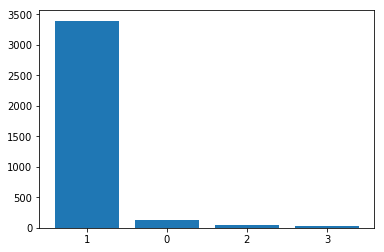

In [235]:
E = dict(Counter(clus1).most_common())
plt.bar(range(len(E)), list(E.values()), align='center')
plt.xticks(range(len(E)), list(E.keys()))

## Distribution of the affinity matrix (Gaussian Transformation)

([<matplotlib.axis.XTick at 0x117c11cf8>,
 <a list of 4 Text xticklabel objects>)

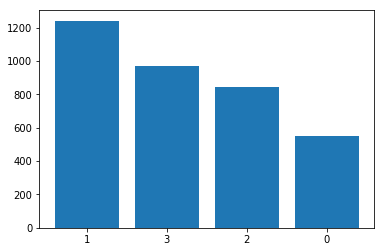

In [234]:
D = dict(Counter(a).most_common())
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))

In [59]:
Counter(clus2)

Counter({0: 3206, 1: 207, 2: 185, 3: 9})

In [60]:
list(zip(clus1, clus2, a))

[(0, 1, 3),
 (0, 1, 3),
 (0, 1, 3),
 (0, 1, 3),
 (0, 1, 3),
 (0, 1, 3),
 (0, 1, 3),
 (0, 1, 3),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0, 0, 2),
 (0,

In [61]:
# now that we know 
venues_df_2017['category_sci'] = clus2
venues_df_2017['category_self'] = a

In [62]:
venues_df_2017

,country,localized_country_name,city,address_1,name,lon,id,lat,repinned,category_sci,category_self
62,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
63,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
64,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
65,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
66,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
67,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
68,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
69,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,3
70,au,Australia,Sydney,Level ...,Atlassian,151.20...,255047...,-33.868355,False,0,3
71,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,0,3


In [66]:
events_df_2017_ven = pd.concat([events_df_2017, venues_df_2017], axis=1)
events_df_2018_ven = pd.concat([events_df_2018, venues_df_2018], axis=1)

In [67]:
events_df_2018_ven.columns

Index(['Unnamed: 0', 'level_0', 'created', 'description', 'duration',
       'event_url', 'fee', 'group', 'headcount', 'how_to_find_us', 'id',
       'index', 'maybe_rsvp_count', 'name', 'photo_url', 'rating',
       'rsvp_limit', 'status', 'time', 'updated', 'utc_offset', 'venue',
       'visibility', 'waitlist_count', 'why', 'yes_rsvp_count',
       'time_timestamp', 'country', 'localized_country_name', 'city',
       'address_1', 'name', 'lon', 'id', 'lat', 'repinned'],
      dtype='object')

In [68]:
events_df_2017_ven.columns

Index(['Unnamed: 0', 'level_0', 'created', 'description', 'duration',
       'event_url', 'fee', 'group', 'headcount', 'how_to_find_us', 'id',
       'index', 'maybe_rsvp_count', 'name', 'photo_url', 'rating',
       'rsvp_limit', 'status', 'time', 'updated', 'utc_offset', 'venue',
       'visibility', 'waitlist_count', 'why', 'yes_rsvp_count',
       'time_timestamp', 'country', 'localized_country_name', 'city',
       'address_1', 'name', 'lon', 'id', 'lat', 'repinned', 'category_sci',
       'category_self'],
      dtype='object')

In [69]:
# bring the group.id out and then join
events_df_2017_ven['group_id'] = list(events_df_2017_ven.group.apply(lambda x: ast.literal_eval(x)['id'] if pd.notnull(x) else ""))
events_df_2018_ven['group_id'] = list(events_df_2018_ven.group.apply(lambda x: ast.literal_eval(x)['id'] if pd.notnull(x) else ""))

In [70]:
df = pd.merge(events_df_2017_ven, df_groups, left_on='group_id', right_on='id', how='inner')
df_test = pd.merge(events_df_2018_ven, df_groups, left_on='group_id', right_on='id', how='inner')

In [71]:
df = df.loc[:,~df.columns.duplicated()]
df_test = df_test.loc[:,~df_test.columns.duplicated()]

In [73]:
df['short_cat'] = list(df.category.apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else ""))
df_test['short_cat'] = list(df_test.category.apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else ""))

In [74]:
i__ = df.groupby(['short_cat']).count().iloc[:,0].sort_values(ascending=False)

In [75]:
df.groupby(['short_cat']).count()
short_cat_filter = i__[:8].index

In [76]:
i__

short_cat
language/ethnic identity    626
socializing                 624
games                       449
tech                        329
new age/spirituality        296
outdoors/adventure          280
career/business             155
food/drink                  153
health/wellbeing            141
fitness                     126
sports/recreation           121
religion/beliefs             73
fine arts/culture            48
hobbies/crafts               43
community/environment        33
movements/politics           29
LGBT                         22
photography                  14
music                        14
parents/family               12
support                       9
movies/film                   7
education/learning            1
dancing                       1
cars/motorcycles              1
Name: Unnamed: 0_x, dtype: int64

In [240]:
for x in list(short_cat_filter):
    print(r"\item",x)

\item language/ethnic identity
\item socializing
\item games
\item tech
\item new age/spirituality
\item outdoors/adventure
\item career/business
\item food/drink


In [78]:
df = df[df.short_cat.isin(short_cat_filter)]

In [79]:
df_test = df_test[df_test.short_cat.isin(short_cat_filter)]

In [80]:
i__ = df.groupby(['short_cat']).count().iloc[:,0].sort_values(ascending=False)
i_ = df.groupby(['short_cat']).count().iloc[:,0].sort_values(ascending=False)[:8]
my_xticks = i_.index
x = list(range(len(my_xticks)))
plt.xticks(x, my_xticks, fontsize=8, rotation=90)
plt.plot(x, i_.values)
plt.show()

In [81]:
temp = df.groupby(['category_self', 'short_cat']).count()
temp

Unnamed: 0_x  level_0_x  created_x  description_x  \
categor... short_cat                                                       
0          career/...         41            41         41         40       
           food/drink         19            19         19         17       
           games             213           213        213        213       
           languag...         86            86         86         86       
           new age...         50            50         50         50       
           outdoor...         89            89         89         87       
           sociali...        178           178        178        178       
           tech                7             7          7          7       
1          career/...         95            95         95         94       
           food/drink         12            12         12          4       
           games              47            47         47         47       
           languag...        199           199        199        199       
           new age...          5             5          5          5       
           outdoor...        123           123        123        123       
           sociali...        178           178        178        178       
           tech              186           186        186        185       
2          career/...         11            11         11         11       
           food/drink          3             3          3          2       
           languag...        131           131        131        131       
           new age...        239           239        239        239       
           outdoor...          5             5          5          5       
           sociali...         67            67         67         67       
           tech               39            39         39         39       
3          career/...          8             8          8          8       
           food/drink        119           119        119        118       
           games             189           189        189        189       
           languag...        210           210        210        208       
           new age...          2             2          2          2       
           outdoor...         63            63         63         63       
           sociali...        201           201        201        201       
           tech               97            97         97         97       

                       duration  event_url  fee  group  headcount  \
categor... short_cat                                                
0          career/...         5         41   12     41         41   
           food/drink         2         19    0     19         19   
           games             54        213    0    213        213   
           languag...         0         86    0     86         86   
           new age...         3         50    0     50         50   
           outdoor...        20         89    1     89         89   
           sociali...        18        178    0    178        178   
           tech               5          7    0      7          7   
1          career/...        29         95    1     95         95   
           food/drink        11         12    0     12         12   
           games             35         47    0     47         47   
           languag...         7        199    0    199        199   
           new age...         2          5    0      5          5   
           outdoor...       114        123  110    123        123   
           sociali...        15        178    0    178        178   
           tech             151        186    1    186        186   
2          career/...         3         11    1     11         11   
           food/drink         2          3    0      3          3   
           languag...         0        131    0    131        131   
           new age...       193        239   51    239        239

In [82]:
a = []


In [83]:
global_arr = {}
for i in range(NUM_CLUSTERS):
    temp = df.groupby(['category_self', 'short_cat']).count()
    try:
        indicies = temp.loc[i].index
    except (KeyError, IndexError) as e:
        print(e)
        continue
    arr = []
    for j in indicies:
        z__ = temp.loc[i]
        arr.append(z__.level_0_x[j]/i__[j])
    global_arr[i] = dict(zip(indicies, arr))

In [84]:
global_arr

{0: {'career/business': 0.26451612903225807,
  'food/drink': 0.12418300653594772,
  'games': 0.47438752783964366,
  'language/ethnic identity': 0.13738019169329074,
  'new age/spirituality': 0.16891891891891891,
  'outdoors/adventure': 0.31785714285714284,
  'socializing': 0.28525641025641024,
  'tech': 0.021276595744680851},
 1: {'career/business': 0.61290322580645162,
  'food/drink': 0.078431372549019607,
  'games': 0.10467706013363029,
  'language/ethnic identity': 0.31789137380191695,
  'new age/spirituality': 0.016891891891891893,
  'outdoors/adventure': 0.43928571428571428,
  'socializing': 0.28525641025641024,
  'tech': 0.56534954407294835},
 2: {'career/business': 0.070967741935483872,
  'food/drink': 0.019607843137254902,
  'language/ethnic identity': 0.20926517571884984,
  'new age/spirituality': 0.80743243243243246,
  'outdoors/adventure': 0.017857142857142856,
  'socializing': 0.10737179487179487,
  'tech': 0.11854103343465046},
 3: {'career/business': 0.051612903225806452,

In [241]:
global_arr
map_dict = {}
for x in short_cat_filter:
    dict1 = {}
    for cat, d in global_arr.items():
        dict1[cat] = d.get(x, 0)
    p = max(dict1, key=dict1.get)
    print(p, x)
    map_dict[x] = p

3 language/ethnic identity
3 socializing
0 games
1 tech
2 new age/spirituality
1 outdoors/adventure
1 career/business
3 food/drink


# Plotting a sample of the groupings

In [288]:
sub_df = df.groupby('category_self').apply(pd.DataFrame.sample, frac=0.10).reset_index(drop=True)
colours = ['red', 'green', 'gray', 'blue']
map_hooray = folium.Map(location=[-33.867249, 151.20694],
                        zoom_start =10) # Uses lat then lon. The bigger the zoom number, the closer in you get

for i in range(NUM_CLUSTERS):
    # remove nans
    for x, y in sub_df[sub_df.category_self==i][['lat_x', 'lon_x']].apply(tuple, axis=1):
#         folium.Marker([x, y], popup=str(i), icon=folium.Icon(color=colours[i])).add_to(map_hooray)
        folium.Marker([x, y], popup="spec cluster " + str(i), icon=folium.Icon(color=colours[i])).add_to(map_hooray)


map_hooray

#### As we can see, the games tend to outside the city while tech is well and truly centred around the cbd

## Let's try some KNN classification

In [255]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=15)

In [271]:
X = list(zip(df.lat_x, df.lon_x))
# y = df.short_cat
y = df.category_self
neigh.fit(X, y) 


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [272]:
df_test.loc[0][['short_cat', 'lat_x', 'lon_y']]
df_test[['lat_x', 'lon_y']].values

array([[ -33.868355  ,  151.21000671],
       [ -33.867249  ,  151.21000671],
       [ -33.867249  ,  151.21000671],
       ..., 
       [ -33.89286   ,  151.21000671],
       [ -33.89286   ,  151.21000671],
       [ -33.89286   ,  151.21000671]])

In [273]:
neigh.predict(df_test[['lat_x', 'lon_y']].values)

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

In [274]:
df_test['pred_cat'] = neigh.predict(df_test[['lat_x', 'lon_y']].values)
df_test['act_cat'] = [map_dict[x] for x in df_test['short_cat']]


In [278]:
X = list(zip(df.lat_x, df.lon_x))
y = df.short_cat
# y = df.category_self
neigh.fit(X, y) 
df_test['pred_meet'] = neigh.predict(df_test[['lat_x', 'lon_y']].values)


# Accuracy Rate

### KNN on spectral clustering groups

In [280]:
df_test[df_test['pred_cat'] == df_test['act_cat']].count()["level_0_x"]/df_test.shape[0]

0.45580110497237569

### KNN on Meetup categories

In [281]:
df_test[df_test['pred_meet'] == df_test['short_cat']].count()["level_0_x"]/df_test.shape[0]

0.22375690607734808

### Random Classifier

In [266]:
# Random baseline
df_test['rand_cat'] = np.random.randint(0, 3, df_test.shape[0])
df_test[df_test['act_cat'] == df_test['rand_cat']].count()["level_0_x"]/df_test.shape[0]

0.16574585635359115

In [189]:
points = MultiPoint([(0.0, 0.0), (1.0, 1.0)])
print(points.centroid) #True centroid, not necessarily an existing point
print(points.representative_point()) #A represenative point, not centroid,
                                    #that is guarnateed to be with the geometry.

POINT (0.5 0.5)
POINT (0 0)


In [190]:
def group_to_centroid_coords(group):
    a = MultiPoint(list(zip(df[df.category_x == group].lat_x, df[df.category_x == group].lon_x))).centroid.coords
    return list(a)[0]

In [ ]:
def cat_to_centroid_coords(group):
    a = MultiPoint(list(zip(df[df.category_x == group].lat_x, df[df.category_x == group].lon_x))).centroid.coords
    return list(a)[0]

In [277]:
print(list(points.centroid.coords)[0]) #True centroid, not necessarily an existing point
lat,lon = list(points.centroid.coords)[0]

(-33.68911344803378, 150.34314424719102)


In [294]:
group_to_centroid_coords(0)

(-33.68911344803378, 150.34314424719102)

In [287]:
sub_df = df.groupby('category_self').apply(pd.DataFrame.sample, frac=0.25).reset_index(drop=True)
colours = ['red', 'green', 'gray', 'blue']
map_hooray = folium.Map(location=[-33.867249, 151.20694],
                        zoom_start =10) # Uses lat then lon. The bigger the zoom number, the closer in you get

for i in range(NUM_CLUSTERS):
    # remove nans
    for x, y in sub_df[sub_df.category_self==i][['lat_x', 'lon_x']].apply(tuple, axis=1):
#         folium.Marker([x, y], popup=str(i), icon=folium.Icon(color=colours[i])).add_to(map_hooray)
        folium.Marker([x, y], popup="spec cluster " + str(i), icon=folium.Icon(color=colours[i])).add_to(map_hooray)


map_hooray

0
1
2
3
